In [106]:
import os
import numpy as np
import pandas as pd
import pretty_midi


from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import pretty_midi
import librosa


### Data Pre-Processing

#### Load Files 
We will be loading files in 2 ways: 
- for piano rolls generation
- labeled with features extracted: 
  - `avg_pitch`
  - `std_pitch`
  - `avg_duration` 
  - `std_duration` 
  - `avg_velocity` 
  - `std_velocity` 
  - `note_vector` -  the sequence of note pitches per midi file
  - `duration_vector`  -  the sequence of note durations per midi file 
  - `velocity_vector` - the sequence of note velocities per midi file

In [107]:
# Specify the directory
bach_dir = 'music_data/midiclassics/Bach'
beethoven_dir = 'music_data/midiclassics/Beethoven'
chopin_dir = 'music_data/midiclassics/Chopin'
mozart_dir = 'music_data/midiclassics/Mozart'

composer_dirs = [bach_dir, beethoven_dir, chopin_dir, mozart_dir]

#### For CNN

In [108]:
def compile_midi_files(directory):
    # Initialize an empty list to store the paths of all MIDI files
    midi_files = []

    # Use os.walk to iterate over each subdirectory in the current directory
        # 'root' is the path to the current directory
        # 'dirs' is a list of the names of the subdirectories in 'root'
        # 'files' is a list of the names of the non-directory files in 'root'
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is a MIDI file
            if file.endswith('.mid'):
                # If it is, construct the full path to the file and add it to the list
                midi_files.append(os.path.join(root, file))

    # Return the list of all MIDI files
    return midi_files

# Compile all MIDI files from each composer
bach_midi_files = compile_midi_files(bach_dir)
beethoven_midi_files = compile_midi_files(beethoven_dir)
chopin_midi_files = compile_midi_files(chopin_dir)
mozart_midi_files = compile_midi_files(mozart_dir)

# Print the number of MIDI files for each composer
print(f'Bach MIDI files: {len(bach_midi_files)}')
print(f'Beethoven MIDI files: {len(beethoven_midi_files)}')
print(f'Chopin MIDI files: {len(chopin_midi_files)}')
print(f'Mozart MIDI files: {len(mozart_midi_files)}')

Bach MIDI files: 925
Beethoven MIDI files: 212
Chopin MIDI files: 136
Mozart MIDI files: 257


#### For LSTM

In [109]:
def extract_features(midi_file):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    
    # Extract note pitches
    pitches = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitches.append(note.pitch)
    
    # Extract note durations
    durations = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            durations.append(note.end - note.start)
    
    # Extract note velocities
    velocities = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            velocities.append(note.velocity)
    
    # Compute average and standard deviation for features
    features = {
        'avg_pitch': np.mean(pitches),
        'std_pitch': np.std(pitches),
        'avg_duration': np.mean(durations),
        'std_duration': np.std(durations),
        'avg_velocity': np.mean(velocities),
        'std_velocity': np.std(velocities),
        'note_vector': pitches,  # Add the sequence of note pitches as a feature
        'duration_vector': durations,  # Add the sequence of note durations as a feature
        'velocity_vector': velocities  # Add the sequence of note velocities as a feature
    }
    
    return features


def load_data(directory, current_label, data, success_files, exception_files):
    print(f'Loading {directory} for {current_label}...')
       # Use os.walk to iterate over each subdirectory in the current directory
        # 'root' is the path to the current directory
        # 'dirs' is a list of the names of the subdirectories in 'root'
        # 'files' is a list of the names of the non-directory files in 'root'
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is a MIDI file
            if file.endswith('.mid'):
                file_path = os.path.join(root, file)
                print(f'Processing {file}...')
                print(f'File path: {file_path}')
                try: 
                    features = extract_features(file_path)
                    features['composer'] = current_label
                    data.append(features)
                    success_files.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}") 
                    exception_files.append(file_path)

def create_dataframe(data, max_sequence_length = 100):
    df = pd.DataFrame(data)

    df['composer'] = df['composer'].map({0: 'Bach', 1: 'Beethoven', 2: 'Chopin', 3: 'Mozart'})
    df = pd.DataFrame(data)
    
    # Pad sequences to a fixed length
    note_vectors = pad_sequences(df['note_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    duration_vectors = pad_sequences(df['duration_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    velocity_vectors = pad_sequences(df['velocity_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    
    # Add padded sequences to the dataframe
    df['note_vector'] = list(note_vectors)
    df['duration_vector'] = list(duration_vectors)
    df['velocity_vector'] = list(velocity_vectors)
    return df
            
data = []
success_files = []
exception_files = []

# Load data
for current_label, composer_dir in enumerate(composer_dirs):
    load_data(composer_dir, current_label, data, success_files, exception_files)

# Create dataframe
df = create_dataframe(data)

print(f"Success files: {len(success_files)}")
print(f"Exception files: {len(exception_files)}")

# Print shape of data
print(f"Data shape: {df.shape}")

# List all exceptions
for file in exception_files:
    print(file)

display(df.head())

Loading music_data/midiclassics/Bach for 0...
Processing Bwv0997 Partita for Lute 1mov.mid...
File path: music_data/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid
Processing Bwv0535 Prelude and Fugue.mid...
File path: music_data/midiclassics/Bach/Bwv0535 Prelude and Fugue.mid
Processing Bwv0806 English Suite n1 05mov.mid...
File path: music_data/midiclassics/Bach/Bwv0806 English Suite n1 05mov.mid
Processing Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid...
File path: music_data/midiclassics/Bach/Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid
Processing Jesu Joy of Man Desiring.mid...
File path: music_data/midiclassics/Bach/Jesu Joy of Man Desiring.mid
Processing Prelude and Fugue in C Sharp BWV 872.mid...
File path: music_data/midiclassics/Bach/Prelude and Fugue in C Sharp BWV 872.mid
Processing Bwv0582 Passacaglia and Fugue.mid...
File path: music_data/midiclassics/Bach/Bwv0582 Passacaglia and Fugue.mid
Processing Bwv0527 Sonate en trio n3.mid...
File path: music_data/midiclas

/Users/kseniakoldaeva/USD/AAI-511/AAI-511-final-project/final_project/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Processing Bwv0806 English Suite n1 03mov .mid...
File path: music_data/midiclassics/Bach/Bwv0806 English Suite n1 03mov .mid
Processing Bwv0560 Short Prelude and Fugue n8 (Spurious).mid...
File path: music_data/midiclassics/Bach/Bwv0560 Short Prelude and Fugue n8 (Spurious).mid
Processing Bwv0811 English Suite n6 2mov.mid...
File path: music_data/midiclassics/Bach/Bwv0811 English Suite n6 2mov.mid
Processing Bwv1005 Violin Sonata n3 3mov Largo.mid...
File path: music_data/midiclassics/Bach/Bwv1005 Violin Sonata n3 3mov Largo.mid
Processing Bwv0559 Short Prelude and Fugue n7 (Spurious).mid...
File path: music_data/midiclassics/Bach/Bwv0559 Short Prelude and Fugue n7 (Spurious).mid
Processing Bwv0556 Short Prelude and Fugue n4 (Spurious).mid...
File path: music_data/midiclassics/Bach/Bwv0556 Short Prelude and Fugue n4 (Spurious).mid
Processing Bwv1014 Harpsicord and Violin Sonata 2mov.mid...
File path: music_data/midiclassics/Bach/Bwv1014 Harpsicord and Violin Sonata 2mov.mid
Processing

,avg_pitch,std_pitch,avg_duration,std_duration,avg_velocity,std_velocity,note_vector,duration_vector,velocity_vector,composer
0,67.425793,13.362625,0.317746,0.217394,100.000000,0.000000,"[41, 39, 51, 50, 51, 39, 38, 43, 36, 53, 51, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0
1,65.095977,8.985751,0.331267,0.483278,94.226798,3.158550,"[46, 45, 46, 41, 48, 43, 45, 38, 62, 61, 62, 5...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[102, 102, 102, 102, 102, 102, 102, 102, 102, ...",0
2,63.708571,12.281183,0.251194,0.257226,107.000000,0.000000,"[57, 57, 45, 38, 50, 49, 47, 49, 50, 47, 46, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[107, 107, 107, 107, 107, 107, 107, 107, 107, ...",0
3,56.748663,9.189533,0.241845,0.475768,97.967914,6.821956,"[48, 46, 48, 41, 44, 48, 41, 43, 45, 46, 38, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0
4,61.821760,12.759427,0.589599,0.554350,56.877460,13.815553,"[43, 40, 36, 35, 40, 38, 36, 37, 38, 31, 43, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[57, 58, 59, 60, 61, 62, 63, 65, 67, 69, 72, 7...",0


/var/folders/gs/bdy86gys0sl94djgd6hqvqd40000gq/T/ipykernel_49470/1926333518.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='composer', palette='viridis')


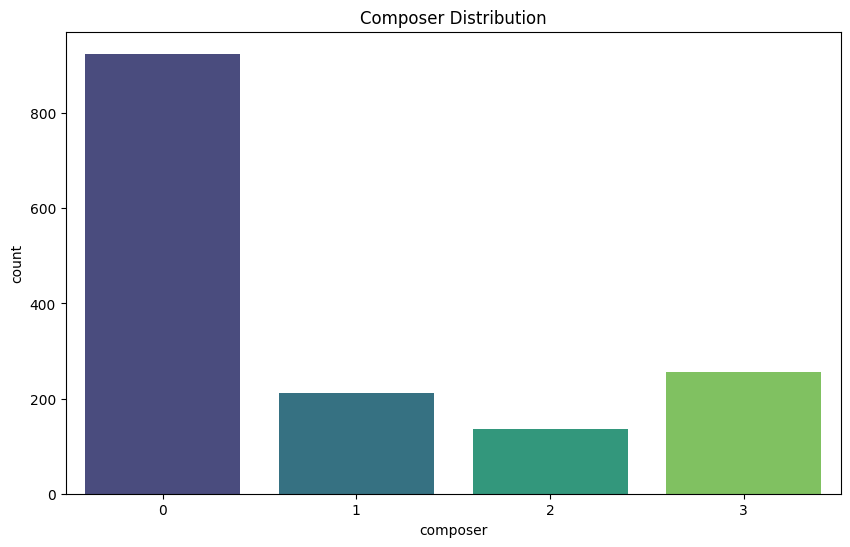

In [110]:
# plot composer distribution, add color for each composer
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='composer', palette='viridis')
plt.title('Composer Distribution')
plt.show()

/var/folders/gs/bdy86gys0sl94djgd6hqvqd40000gq/T/ipykernel_49470/2397650569.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='composer', y='avg_pitch', palette='viridis')


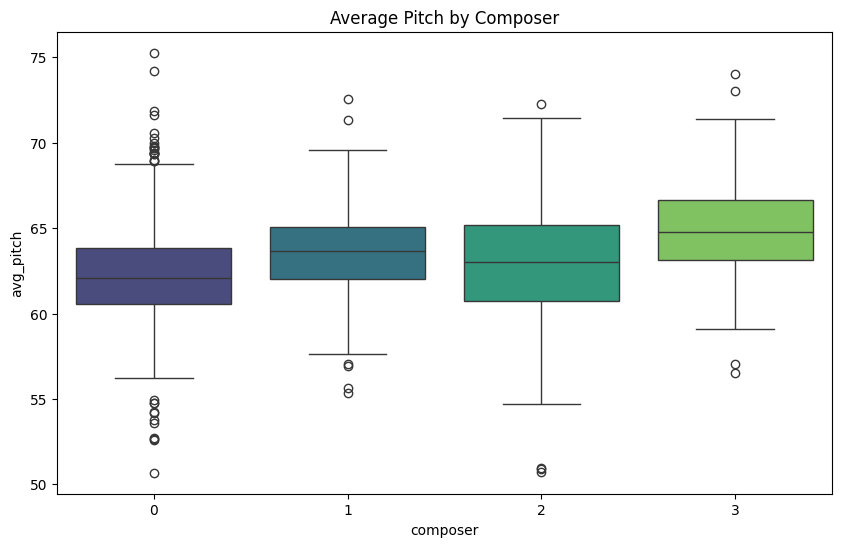

/var/folders/gs/bdy86gys0sl94djgd6hqvqd40000gq/T/ipykernel_49470/2397650569.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='composer', y='avg_duration', palette='viridis')


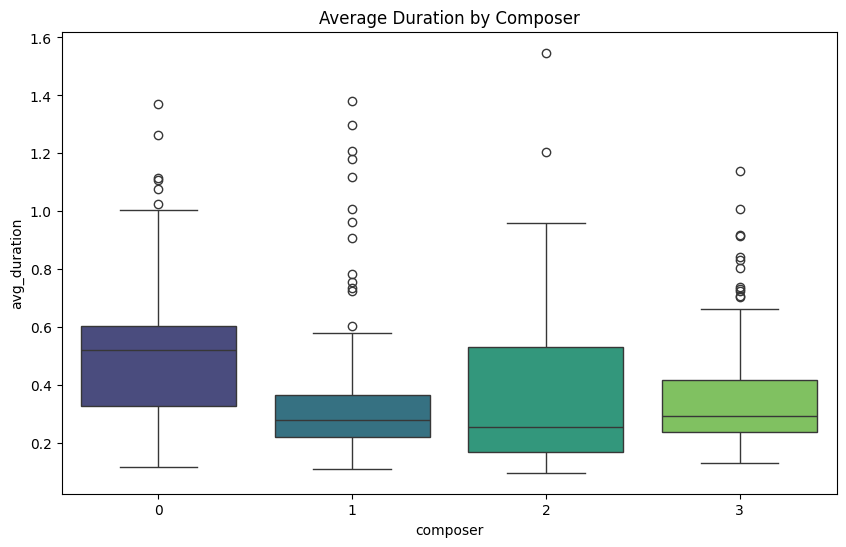

/var/folders/gs/bdy86gys0sl94djgd6hqvqd40000gq/T/ipykernel_49470/2397650569.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='composer', y='avg_velocity', palette='viridis')


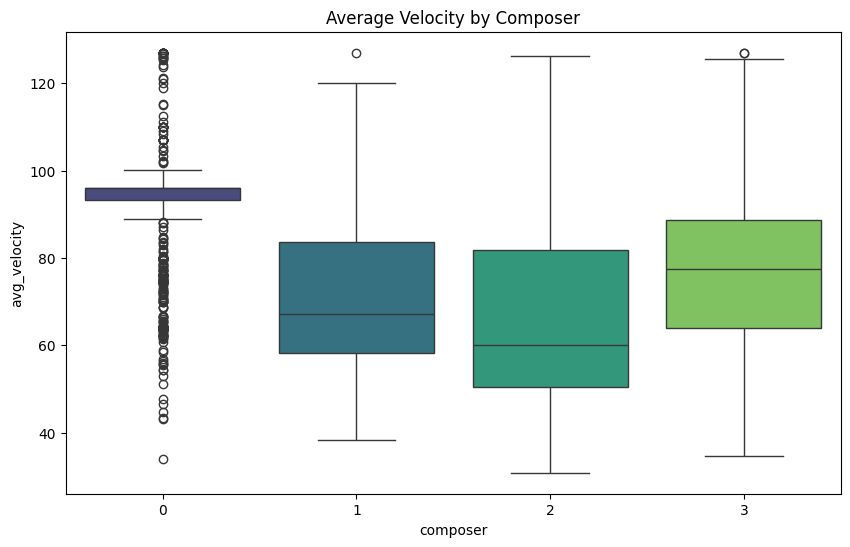

In [111]:
# plot average pitch for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_pitch', palette='viridis')
plt.title('Average Pitch by Composer')
plt.show()

# plot average duration for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_duration', palette='viridis')
plt.title('Average Duration by Composer')
plt.show()

# plot average velocity for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_velocity', palette='viridis')
plt.title('Average Velocity by Composer')
plt.show()

### Address Class Imbalance 

#### For CNN

In [112]:
# Randomly sample 136 MIDI files from each composer
bach_sample = np.random.choice(bach_midi_files, 136, replace=False)
beethoven_sample = np.random.choice(beethoven_midi_files, 136, replace=False)
chopin_sample = np.random.choice(chopin_midi_files, 136, replace=False)
mozart_sample = np.random.choice(mozart_midi_files, 136, replace=False)

#### For LSTM

In [113]:
# Prepare the dataset
X = df.drop(columns=['composer'])
y = df['composer']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Use RandomUnderSampler to handle class imbalance
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y_encoded)

# Convert resampled data back to DataFrame for easier handling
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.Series(y_resampled, name='composer')

# Verify class distribution after undersampling
print(y_resampled_df.value_counts())

0    136
1    136
2    136
3    136
Name: composer, dtype: int64


### Feature Extraction 

#### For CNN

/Users/kseniakoldaeva/USD/AAI-511/AAI-511-final-project/final_project/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/var/folders/gs/bdy86gys0sl94djgd6hqvqd40000gq/T/ipykernel_49470/1840232719.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(midi_file.get_piano_roll(fs)[start_pitch:end_pitch],


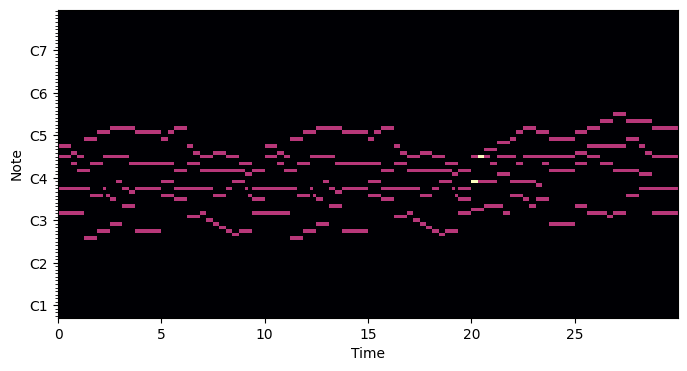

In [114]:
def plot_piano_roll(midi_file, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(midi_file.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
    
plt.figure(figsize=(8, 4))

# Initialize an empty list to store the PrettyMIDI objects
bach_pretty_midi_objects = []

# Iterate over each MIDI file in the bach_midi_files list
for midi_file in bach_sample:
    # Convert the MIDI file to a PrettyMIDI object and append it to the list
    bach_pretty_midi_objects.append(pretty_midi.PrettyMIDI(midi_file))
    
plot_piano_roll(bach_pretty_midi_objects[0], 21, 108)

In [115]:
print(bach_pretty_midi_objects[0].get_piano_roll())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


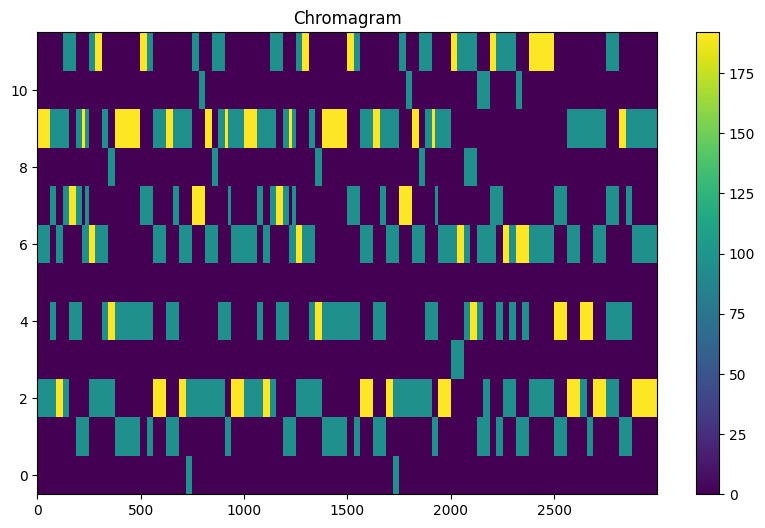

In [116]:
def plot_chromagram(midi_data):
    # Get chroma features of MIDI data
    chroma = midi_data.get_chroma()

    # Plot chromagram
    plt.figure(figsize=(10, 6))
    plt.imshow(chroma, aspect='auto', origin='lower', interpolation='none')
    plt.colorbar()
    plt.title('Chromagram')
    plt.show()

plot_chromagram(bach_pretty_midi_objects[0])

#### For LSTM 

In [117]:
# Extract and reshape the sequence features for LSTM
note_vectors = np.stack(X_resampled_df['note_vector'].values)
duration_vectors = np.stack(X_resampled_df['duration_vector'].values)
velocity_vectors = np.stack(X_resampled_df['velocity_vector'].values)

# Combine the features into a single 3D array
X_lstm = np.stack((note_vectors, duration_vectors, velocity_vectors), axis=-1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_resampled, test_size=0.2, random_state=42)

### Model Building

#### CNN

#### LSTM

In [118]:
# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/Users/kseniakoldaeva/USD/AAI-511/AAI-511-final-project/final_project/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Training

#### CNN

#### LSTM

In [119]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3460 - loss: 1.3345 - val_accuracy: 0.5057 - val_loss: 1.1912
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4412 - loss: 1.1696 - val_accuracy: 0.5057 - val_loss: 1.0790
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5421 - loss: 1.0933 - val_accuracy: 0.4713 - val_loss: 1.0265
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5161 - loss: 1.0295 - val_accuracy: 0.4828 - val_loss: 0.9851
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5714 - loss: 0.9910 - val_accuracy: 0.4828 - val_loss: 1.0401
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5584 - loss: 0.9716 - val_accuracy: 0.5172 - val_loss: 1.0373
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6197 - loss: 0.9308 - val_accuracy: 0.5172 - val_loss: 0.9960
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6111 - loss: 0.9584 - val_accuracy: 0.5402 - v

### Model Evaluation

### Model Optimization